## Econometric estimation of an IRL-based market portfolio model. Part II: QED

Welcome to your final course project on Advanced Topic RL in Finance. In this project you will: 

- Explore and estimate an IRL-based model of market returns (the "QED" model) that is obtained by a generalization of   a model that you analyzed in the previous course
- Respectively, you are expected to re-utilize parts of your previous code from the course project from Course 3: RL (but you can also start from scratch - the template provided here is nearly identical to the one offered to you in course 3)
- Investige the role of non-linearities in price dynamics
- Investigate the role and impact of choices of different signals on model estimation and trading strategies
 

**Instructions for project structure and grading principles :**

- This is a project that will be graded based on a peer-to-peer review. The project consists of four parts. The maximum score for each part is 10, so that maximum score you can give your peers (and they can give you) is 40. The parts are as follows (more detailed instructions are in specific cells below):

- **Part 1**: Estimate the model using the DJI portfolio of 30 stocks, first without signals, and then using simple signals such as simple moving averages constructed below (Max 10 point).

- **Part 2**: Explore the implications of calibrated model parameters for default probabilities of stocks in your portfolio. Present your conclusions and observations. (Max 10 point).

- **Part 3**: Experiment with other signals and investigate the impact on model calibration obtained with alternative signals. Present your conclusions and observations. (Max 10 points).

- **Part 4** : Show me something else. This part is optional. Come up with your own idea of an interesting analysis.
For example, you can repeat your analysis for the S&P portfolio.
Or maybe you can build a strategy using an optimal market-implied policy estimated from this model, and compare it with PCA and absorption ratio strategies that we built in Course 2. Or anything else.  (Max 10 points).

**Instructions for formatting your notebook and packages use can use **

- Use one or more cells of the notebook for each section of the project. Each section is marked by a header cell below. Insert your cells between them without changing the sequence. 

- Think of an optimal presentation of your results and conclusions. Think of how hard or easy it will be for your fellow students to follow your logic and presentation. When you are grading others, you can add or subtract point for the quality of presentation.

- You will be using Python 3 in this project. Using TensorFlow is encouraged but is not strictly necessary, you can use optimization algorithms available in scipy or scikit-learn packages. If you use any non-standard packages, you should state all neccessary additional imports (or instructions how to install any additional modules you use in a top cell of your notebook. If you create a new portfolio for parts 3 and 4 in the project, make your code for creating your dataset replicable as well, so that your grader can reproduce your code locally on his/her machine.   

- Try to write a clean code that can be followed by your peer reviewer. When you are the reviewer, you can add or subtract point for the quality of code. 


**After completing this project you will:**
- Get experience with building and estimation of your second IRL based model of market dynamics.
- Develop intuition and understanding about the role of non-linearities in dynamics model. 
- Develop intuition on whether the same model could be calibrated to both equity and credit data.
- Be able to implement trading strategies based on this method.

Let's get started!

## The "Quantum Equlibrium-Disequlibrium" (QED) IRL-based model of stock returns

In Week 3 lectures of our course we presented the "QED" model
$$
d X_t = \kappa X_t  \left( \frac{\theta}{\kappa} - X_t - \frac{g}{\kappa} X_t^2 \right) dt +  X_t \left( {\bf w} {\bf z}_t \, dt + \sigma d W_t \right)
$$

In this project, you will explore calibration of this model to market data.
As in the course project for course 3 you analyzed the same model in the limit $ g = 0 $, you would be able to re-utilize parts of your previous code in this project).


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# read the data to a Dataframe
df_cap = pd.read_csv('dja_cap.csv')

In [3]:
# add dates
dates = pd.bdate_range(start='2010-01-04', end=None, periods=df_cap.shape[0], freq='B')
df_cap['date'] = dates

df_cap.set_index('date',inplace=True)
df_cap.head()


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1.937537e+11,48660795480,4.082033e+10,36460724400,1.420313e+11,1.586155e+11,6.168697e+10,3.337392e+10,1.645038e+11,8.897731e+10,...,25598248500,1.527563e+11,178576382080,27214839130,36638396010,67155918570,41337043020,94536765440,206625627560,3.272107e+11
2010-01-05,1.940887e+11,48553770270,4.215727e+10,36896634000,1.413985e+11,1.597391e+11,6.153308e+10,3.486077e+10,1.653556e+11,9.055040e+10,...,25700093100,1.505775e+11,178634816760,26570118990,36580295160,66152751840,40863360090,94707204320,204568134680,3.284884e+11
2010-01-06,1.910015e+11,49338621810,4.343609e+10,37008725040,1.404781e+11,1.597591e+11,6.120609e+10,3.547838e+10,1.645038e+11,8.958393e+10,...,25543409100,1.500934e+11,177787513900,26193121620,36940520430,65805862410,40314638280,90673484160,204110914040,3.313275e+11
2010-01-07,1.906484e+11,49921314620,4.519446e+10,37158179760,1.411109e+11,1.591572e+11,6.122532e+10,3.550126e+10,1.730218e+11,9.133695e+10,...,26172872700,1.495285e+11,176823341680,26570118990,38358181170,66087124110,40689832680,90133761040,204225219200,3.302865e+11
2010-01-08,1.919159e+11,49885639550,4.475850e+10,37575407520,1.418587e+11,1.594381e+11,6.132150e+10,3.562706e+10,1.767484e+11,8.960963e+10,...,26121202640,1.507389e+11,176589602960,26531872880,37997955900,66218379570,40802391000,90190574000,203196472760,3.289615e+11


## Let us build some signals 

Here we provide a "warm start" by computing two simple moving average signals that you can use as benchmark in your analysis.

### Generate moving averages

In [4]:
# Calculating the short-window (10 days) simple moving average

window_1 = 10

short_rolling = df_cap.rolling(window=window_1).mean()
# short_rolling.head(20)

In [5]:
# Calculating the long-window (30 days) simple moving average

window_2 = 30
long_rolling = df_cap.rolling(window=window_2).mean()
# long_rolling.tail()

### Plot three years of AAPL stock:

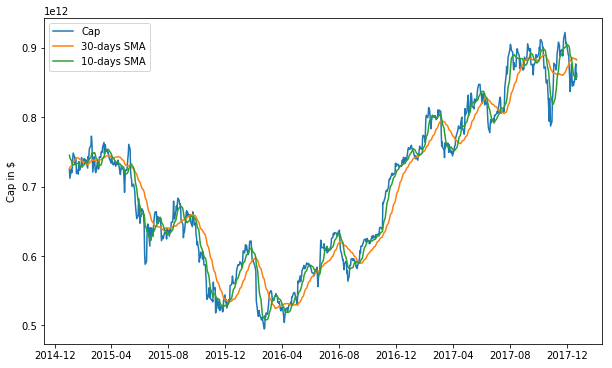

In [6]:
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2017-12-31'

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

ax.plot(df_cap.loc[start_date:end_date, :].index, df_cap.loc[start_date:end_date, 'AAPL'], label='Cap')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'AAPL'], 
          label = '%d-days SMA' % window_2)
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'AAPL'], 
         label = '%d-days SMA' % window_1)

ax.legend(loc='best')
ax.set_ylabel('Cap in $')

plt.show()

## Part 1: Model calibration with or without moving average signals (Max 10 points)

To calibrate the model, it is convenient to use the log-prices instead of prices. Diffusion in the log-space 
$ y = \log x $ is given by the following Langevin equation:

$$
d y_t = - \frac{ \partial V(y)}{\partial y} dt + \sigma dW_t , \; \; \;  V(y)  \equiv - \left( \theta - \frac{\sigma^2}{2} + {\bf w} {\bf z}_t \right) y  + \kappa e^y + \frac{1}{2} g e^{2y}
$$

where $ W_t $ is a standard Brownian motion.
In terms of variables $ y = \log x $, the negative log-likelihood of data is therefore

$$
LL_M (\Theta) = - \log \prod_{t=0}^{T-1} 
\frac{1}{ \sqrt{ 2 \pi  \sigma^2}  } 
\exp \left\{  - \frac{1}{2 \sigma^2} \left(   \frac{ y_{t+ \Delta t} -   y_{t}}{ \Delta t} +  \frac{ \partial V(y)}{\partial y}   
\right)^2
\right\} , 
$$ 

where $ {\bf y}_t  = \log x_t $  now stands for observed values of log-cap. Note that because the model is Markov, the product over $ t = 0, \ldots, T-1 $ does not 
necessarily mean a product of transitions along the same trajectory. The negative log-likelihood should be minimized to estimate parameters $ 
\theta $, $ \sigma $, $ \kappa $, $ g $ and  $ {\bf w} $. You can try to estimate the model first without signals, then with signals.


#### --> In this notebook, we will build the mathmatical model separately from the tensorflow calibration parameters. So, we will tackle the QED Model (as an input to the tensor flow graph) and the structure the tensor flow calibration.

### First, let's start with a model with no Signal! Begining with some Data Preparation.

In [7]:
df_cap_norm = df_cap / df_cap.mean()
Signal_1 = df_cap_norm.rolling(window = window_1).mean().dropna()
Signal_1= Signal_1.iloc[:-1,:]
df_cap_norm_x = df_cap_norm.loc[Signal_1.index]
log_market_cap=np.log(df_cap_norm_x)
#Delta_Market_Cap=df_cap.pct_change(periods=1).shift(0)
Delta_Market_Cap_A=df_cap_norm.diff().dropna().shift(-1)
Delta_Market_Cap_A = Delta_Market_Cap_A / ( 1/252)
Delta_Market_Cap_A = Delta_Market_Cap_A.loc[Signal_1.index]



# Amount of time steps ...
t = log_market_cap.shape[0]

# Number of assets ...
n = log_market_cap.shape[1]

k=1

print( "------------------- Initial Parameters ----------------------" )
print("Number of assets: ", n)
print("Time Periods: ", t)
print("Factual Start Date: ", start_date)
print("Factual End Date: ", end_date)
print("Number of Signals (k): ", k)


------------------- Initial Parameters ----------------------
Number of assets:  30
Time Periods:  2070
Factual Start Date:  2015-01-01
Factual End Date:  2017-12-31
Number of Signals (k):  1


#### Let's work on some functions that will support us in the modelling of the QED equation.

In [8]:

def Delta_no_signal(Y, theta= None, sigma = None, kappa = None, g = None ):
    return -(theta - 0.5 * sigma * sigma)  + kappa * tf.math.exp(Y) + g * tf.math.exp(2.0*Y)


def Gaussian_Var_no_signal(Y, delta_Y, theta= None, sigma = None, kappa = None, g = None ):
    return delta_Y + Delta_no_signal(Y, theta= theta, sigma = sigma, kappa = kappa, g = g )

def Gaussian_log_prob(x_sample, sigma_):
    return tf.cast(tf.size(x_sample), tf.float64) * tf.log(sigma_) + (0.5 / (sigma_*sigma_))*tf.reduce_sum(x_sample * x_sample)


#### Now let's build the basic paramethers for the tensorflow model calibration...

In [9]:
MAX_ITER = 5000
TOL_LOSS = 0.01
LEARNING_RATE = 0.1

TOL_PRM = 1e-4 




#results = pd.DataFrame( [],
                        #index = market_cap_chunk.columns,
                        #columns = [ 'kappa',
                                    #'sigma',
                                    #'sigma^2',
                                    #'w1',
                                    #'w2'] )

convergence= pd.DataFrame( [],
                           index=np.arange(MAX_ITER+2),
                           columns = [ 'interation',
                                       'difference'])


In [10]:
theta_init = 1.0
sigma_init = 1.0
w_init = 1.0

kappa_init = 1.0
g_init = 1.0

# Starting up Tensorflow graphing ...
Y = tf.placeholder(dtype=tf.float64)
delta_Y = tf.placeholder(dtype=tf.float64)

theta = tf.Variable(initial_value=theta_init, dtype=tf.float64)
sigma = tf.Variable(initial_value=sigma_init, dtype=tf.float64)
kappa = tf.Variable(initial_value=kappa_init, dtype=tf.float64)
w = tf.Variable(initial_value=kappa_init, dtype=tf.float64)
g = tf.Variable(initial_value=g_init, dtype=tf.float64)
v = Gaussian_Var_no_signal(Y, delta_Y, theta= theta, sigma = sigma, kappa = kappa, g = g )

llm = Gaussian_log_prob(v, sigma)
    


#clip_w1 = w1.assign(tf.maximum(0., w1))
#clip_w2 = w2.assign(tf.maximum(0., w2))
#clip = tf.group(clip_w1, clip_w2)

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
train_op = optimizer.minimize(llm, var_list=[theta,sigma,w,kappa,g])


val_theta, val_sigma, val_w, val_kappa, val_g = theta_init, sigma_init, w_init, kappa_init, g_init
new_val_theta, new_val_sigma, new_val_w, new_val_kappa, new_val_g = None, None, None, None,None

#### Now let's train the model ...

In [11]:
with tf.Session() as sess:
    sess.run(fetches=tf.global_variables_initializer())

    val_llm = sess.run(fetches=llm, feed_dict={Y:log_market_cap, delta_Y :Delta_Market_Cap_A})
    
    
    i = 1
    
    print( "------------------- Running Calibration ----------------------" )
    print(" iter |       Difference       |   Error")
    
    while True:
        
        sess.run(fetches=train_op, feed_dict={Y:log_market_cap, delta_Y :Delta_Market_Cap_A})
        #sess.run(clip) # force weights to be non-negative

        new_val_llm = sess.run(fetches=llm, feed_dict={Y:log_market_cap, delta_Y :Delta_Market_Cap_A})
        #print(new_val_llm)
        diff = np.abs(new_val_llm - val_llm)
        
        val_llm = new_val_llm
        
        new_val_theta, new_val_sigma, new_val_kappa, new_val_g = sess.run(fetches=[theta,sigma,kappa, g])
        param_err = ( new_val_theta - val_theta )**2
        param_err += (new_val_sigma - val_sigma)**2
        param_err += (new_val_kappa - val_kappa)**2
        param_err += (new_val_g - val_g)**2
        param_err = np.sqrt(param_err)

        val_theta, val_sigma, val_kappa, val_g = new_val_theta, new_val_sigma,new_val_kappa, new_val_g
        
        convergence.iat[i,0]=i
        convergence.iat[i,1]=diff
        
        
        
        print ("{:5} | {:16.4f} | {:12.4f}".format(i,diff,param_err), end="\r")
        
        
        if diff < TOL_LOSS:
            print('Loss function convergence in {} iterations!'.format(i))
            break
            
        if param_err < TOL_PRM:    
            print('parameters convergence in {} iterations!'.format(i))
            break


        if i >= MAX_ITER:
            print('Unable to converge. Max number of iterations reached without convergence.')
            break

        i += 1
        
              

        fitted_means = sess.run(theta, feed_dict={Y:log_market_cap, delta_Y :Delta_Market_Cap_A})
        mean_levels = pd.DataFrame(fitted_means,index=log_market_cap.index,columns=log_market_cap.columns)

print( "------------------- Calibration Results ----------------------" )
print("theta=", new_val_theta)
print("sigma=", new_val_sigma)
#print("weights=", new_val_w)
print("kappa=",new_val_kappa)
print("g=",new_val_g)

------------------- Running Calibration ----------------------
 iter |       Difference       |   Error
Loss function convergence in 2176 iterations!
------------------- Calibration Results ----------------------
theta= 6.596813459
sigma= 3.65149024935
kappa= -0.350585299211
g= 0.182042047381


#### Let's save those results, we'll need them later!

In [12]:
Theta_z=new_val_theta
Sigma_z=new_val_sigma
Weight_z=new_val_w
Kappa_z=new_val_kappa
G_z=new_val_g

print(Theta_z)
print(Sigma_z)

print(Kappa_z)
print(G_z)



6.596813459
3.65149024935
-0.350585299211
0.182042047381


### Now let's calibrate the model using the Signal for the 10 day window. we start by redefining the functions that will support the modeling of the QED.

In [13]:

def Delta(Z, Y, theta= None, sigma = None, w = None, kappa = None, g = None ):
    return -(theta - 0.5 * sigma * sigma) + w * Z * Y + kappa * tf.math.exp(Y) + g * tf.math.exp(2.0*Y)


def Gaussian_Var(Z, Y, delta_Y, theta= None, sigma = None, w = None, kappa = None, g = None ):
    return delta_Y + Delta(Z, Y, theta= theta, sigma = sigma, w = w, kappa = kappa, g = g )

def Gaussian_log_prob(x_sample, sigma_):
    return tf.cast(tf.size(x_sample), tf.float64) * tf.log(sigma_) + (0.5 / (sigma_*sigma_))*tf.reduce_sum(x_sample * x_sample) 



In [14]:
theta_init = 1.0
sigma_init = 1.0
w_init = 1.0
kappa_init = 1.0
g_init = 1.0


# Starting up Tensorflow graphing ...
Y = tf.placeholder(dtype=tf.float64)
delta_Y = tf.placeholder(dtype=tf.float64)
Z = tf.placeholder(dtype=tf.float64)

theta = tf.Variable(initial_value=theta_init, dtype=tf.float64)
sigma = tf.Variable(initial_value=sigma_init, dtype=tf.float64)
w = tf.Variable(initial_value=w_init, dtype=tf.float64)
kappa = tf.Variable(initial_value=kappa_init, dtype=tf.float64)
g = tf.Variable(initial_value=g_init, dtype=tf.float64)
v = Gaussian_Var(Z, Y, delta_Y, theta= theta, sigma = sigma, w = w, kappa = kappa, g = g )
llm = Gaussian_log_prob(v, sigma)


#clip_w1 = w1.assign(tf.maximum(0., w1))
#clip_w2 = w2.assign(tf.maximum(0., w2))
#clip = tf.group(clip_w1, clip_w2)


optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
train_op = optimizer.minimize(llm, var_list=[theta,sigma,w,kappa,g])


val_theta, val_sigma, val_w, val_kappa, val_g = theta_init, sigma_init, w_init, kappa_init, g_init
new_val_theta, new_val_sigma, new_val_w, new_val_kappa, new_val_g = None, None, None, None,None

In [15]:
with tf.Session() as sess:
    sess.run(fetches=tf.global_variables_initializer())

    val_llm = sess.run(fetches=llm, feed_dict={Z:Signal_1, Y:log_market_cap, delta_Y :Delta_Market_Cap_A})
        
    i = 1
    
    print( "------------------- Running Calibration ----------------------" )
    print(" iter |       Difference       |   Error")
    
    while True:
        
        sess.run(fetches=train_op, feed_dict={Z:Signal_1, Y:log_market_cap, delta_Y :Delta_Market_Cap_A})
        #sess.run(clip) # force weights to be non-negative

        new_val_llm = sess.run(fetches=llm, feed_dict={Z:Signal_1, Y:log_market_cap, delta_Y :Delta_Market_Cap_A})
        
        diff = np.abs(new_val_llm - val_llm)
        
        val_llm = new_val_llm
        
        new_val_theta, new_val_sigma, new_val_w, new_val_kappa, new_val_g = sess.run(fetches=[theta,sigma,w,kappa, g])
        param_err = ( new_val_theta - val_theta )**2
        param_err += (new_val_sigma - val_sigma)**2
        param_err += (new_val_w - val_w)**2
        param_err += (new_val_kappa - val_kappa)**2
        param_err += (new_val_g - val_g)**2
        param_err = np.sqrt(param_err)

        val_theta, val_sigma, val_w, val_kappa, val_g = new_val_theta, new_val_sigma, new_val_w, new_val_kappa, new_val_g
        
        convergence.iat[i,0]=i
        convergence.iat[i,1]=diff
        
        
        
        print ("{:5} | {:16.4f} | {:12.4f}".format(i,diff,param_err), end="\r")
        
        
        if diff < TOL_LOSS:
            print('Loss function convergence in {} iterations!'.format(i))
            break
            
        if param_err < TOL_PRM:    
            print('parameters convergence in {} iterations!'.format(i))
            break


        if i >= MAX_ITER:
            print('Unable to converge. Max number of iterations reached without convergence.')
            break

        i += 1
        
        

        fitted_means = sess.run(theta, feed_dict={Z:Signal_1, Y:log_market_cap, delta_Y :Delta_Market_Cap_A})
        mean_levels = pd.DataFrame(fitted_means,index=log_market_cap.index,columns=log_market_cap.columns)

print( "------------------- Calibration Results ----------------------" )
print("theta=", new_val_theta)
print("sigma=", new_val_sigma)
#print("weights=", new_val_w)
print("kappa=",new_val_kappa)
print("g=",new_val_g)

------------------- Running Calibration ----------------------
 iter |       Difference       |   Error
Loss function convergence in 1764 iterations!
------------------- Calibration Results ----------------------
theta= 5.10819489796
sigma= 3.65136499943
kappa= -0.903833161091
g= -0.773604641543


### Let's check the convergence !!!

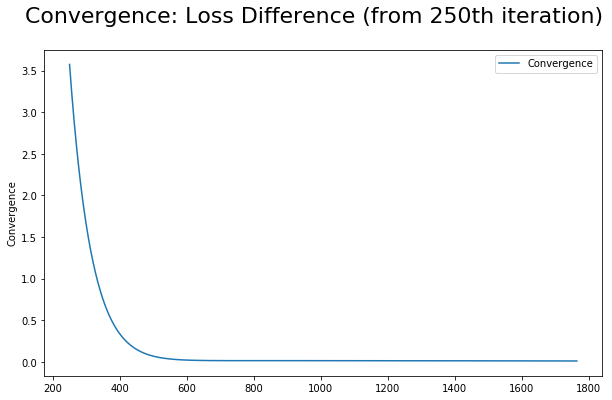

In [16]:
title = 'Convergence: Loss Difference (from 250th iteration)'

start_iter = 250
end_iter = i

fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(1,1,1)

plt.suptitle(title, size=22)
ax.plot(convergence.loc[start_iter:end_iter, :].index, convergence.loc[start_iter:end_iter, 'difference'], label='Convergence')

ax.legend(loc='best')
ax.set_ylabel('Convergence')

plt.show()

### Finally, how did the model perform?

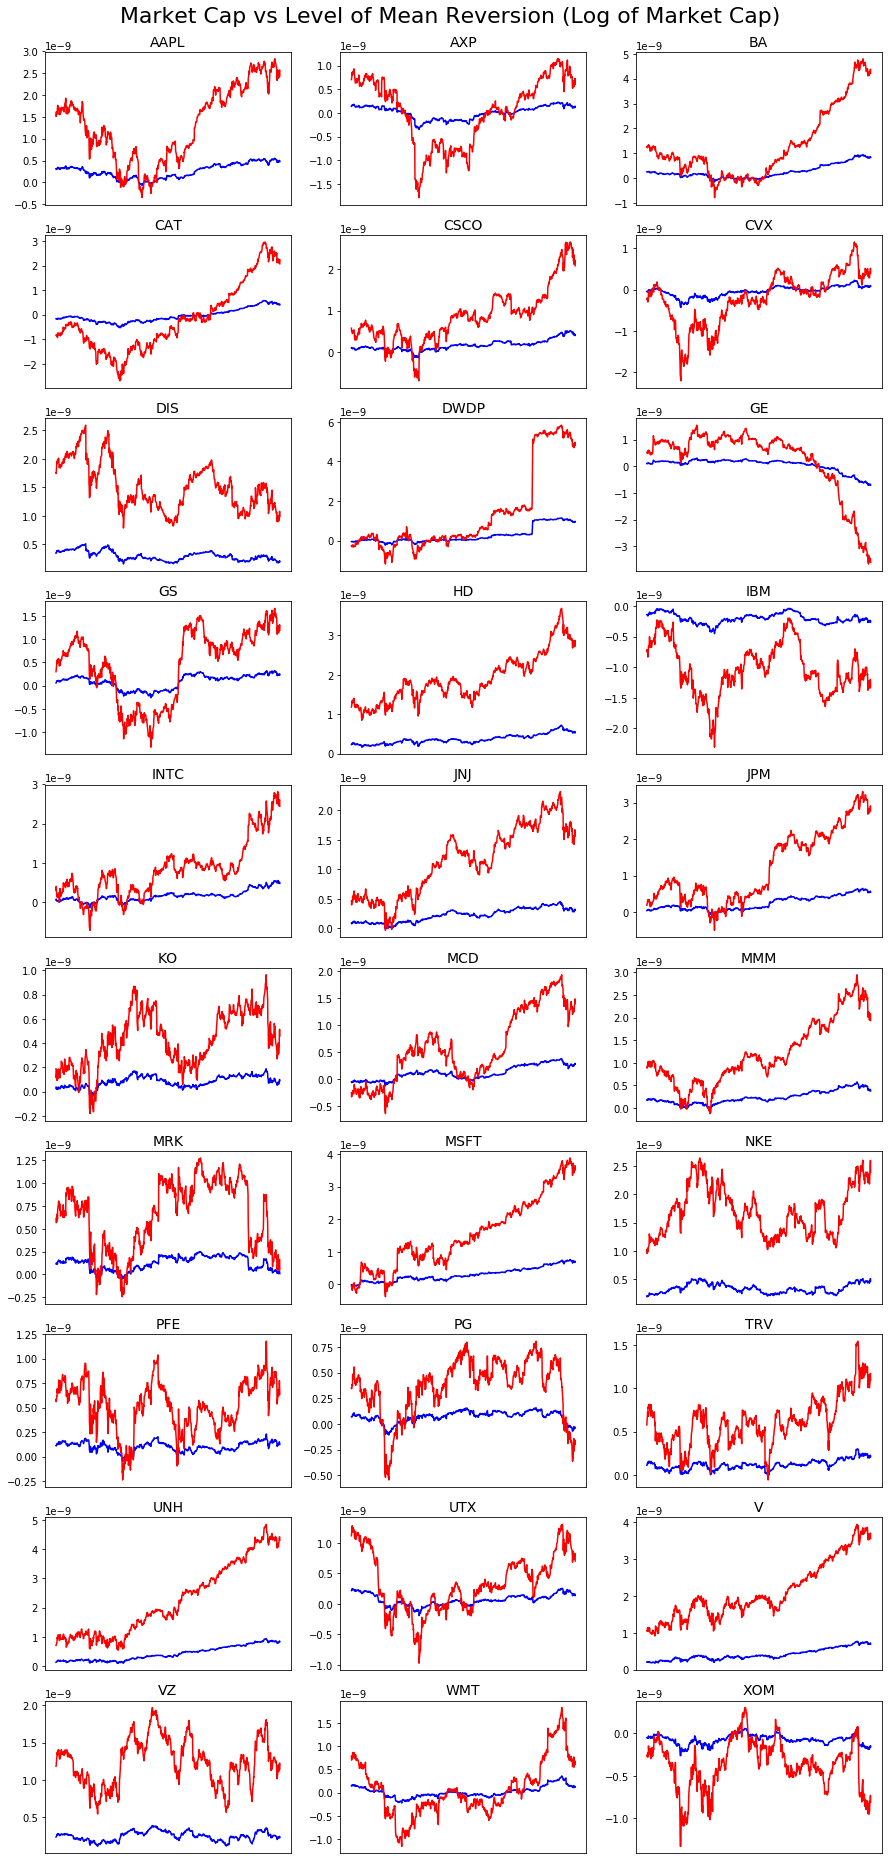

In [17]:
title = 'Market Cap vs Level of Mean Reversion (Log of Market Cap)'

N = df_cap.shape[1]

if N > n: N = n

plt.figure(figsize=(15,N))
plt.suptitle(title, size=22)
ytop = 0.96-0.4*np.exp(-N/5)
plt.subplots_adjust(top=ytop)

stocks = df_cap.columns[:N]
for index, stock in enumerate(stocks,1):
    plt.subplot(np.ceil(N/3),3,index)
    plt.plot((1/1e9)*log_market_cap.loc[start_date:end_date][stock],color='blue',label='Market cap ($Bn)')
    plt.plot((1/1e9)*log_market_cap.loc[start_date:end_date][stock]*mean_levels.loc[start_date:end_date][stock],color='red',label='Mean reversion level')
    plt.title(stock,size=14)
    plt.xticks([])
    
    
plt.show()

## Part 2: Analysis of default rates  (Max 10 point)

For a particle in a potential $ V(y) $ with a metastable minimum $ y = a $ and a barrier with a peak located at $ y = b $, the famous Kramers' escape formula gives the following expression for the escape rate $ r $ (see e.g. the book by van Kampen):

$$ 
r = \frac{\sqrt{ V''(a) \left| V''(b) \right| }}{2 \pi} \exp \left[ - \frac{2}{\sigma^2} (V(b) - V(a) ) \right]
$$

Here $ V''(a) $ and $ V''(b) $ stand for the second derivatives of the potential $ V(y) $ at the minimum and the maximum, respectively. This formula applies as long as the barrier height $ \Delta E \equiv  (V(b) - V(a) \gg \frac{\sigma^2}{2} $. 

Apply the Kramers formula to the QED potential and parameters that you found in your calibration. What range of values of $ r $ do you obtain? Do these values make sense to you? Can you think how you could use the Kramers relation as a way to regularize your MLE calibration?


### Initially, we need to define the equations for potencial, convexity and the Kramer's relation:

In [18]:
def Potential(y, theta = None, sigma =None, kappa =None, g = None):
    return -(theta - 0.5*sigma**2)*y + kappa*np.exp(y)+0.5*np.exp(2*y)

def Convexity(y, kappa = None, g = None):
    return kappa*np.exp(y) + g*np.exp(2*y)

def KramerRate(a, b, theta = None, sigma =None, kappa =None, g = None):
    Cvxty_minimum = Convexity(a, kappa = kappa, g = g)
    Cvxty_barrier = Convexity(b, kappa = kappa, g = g)
    V_a = Potential(a, theta = theta, sigma = sigma, kappa = kappa, g = g)
    V_b = Potential(b, theta = theta, sigma = sigma, kappa = kappa, g = g)    
    r = np.exp((-2.0 / sigma**2)*(V_b - V_a))   # potential over temperature
    r = np.sqrt(2 * np.pi)
    return r

### Now we need to obtain the inflexion points. If we read Igor's paper, we will find that equation 33 is helpful for that. So we will model it.

In [19]:
def InflectionPoints(theta = None, sigma =None, kappa =None, g = None):
    theta_bar = theta - 0.5 * sigma**2
    if kappa**2 + 4 * g * theta_bar <= 0:
        print("Potential does not have metastable shape. see the comment/paper refernce below")
    
    X_min  = ( -kappa + np.sqrt(kappa**2 + 4 * g * theta_bar) )/ ( 2 * g) 
    X_peak = ( -kappa - np.sqrt(kappa**2 + 4 * g * theta_bar) )/ ( 2 * g)

    peta = 'Metastable Potential'
    
    if X_min <= 0 or X_peak <= 0:
        raise Exception("Potential does not have metastable shape. see the comment/paper refernce below")
    return np.log(X_peak), np.log(X_min), peta

#### Here we will use the paramethers obtained on question 1 for the model without signal!

In [20]:
theta= Theta_z
sigma= Sigma_z
kappa= Kappa_z
g= G_z


print(theta)
print(sigma)
print(kappa)
print(g)



6.596813459
3.65149024935
-0.350585299211
0.182042047381


### We may obtain the scape metric using Kramer's relation with the max. and min. points and the other inferred paramethers for the model...

In [21]:
b,a, peta = InflectionPoints(theta = theta, sigma = sigma, kappa = kappa, g = g)

print( "------------------- Results ----------------------" )
print("Min=", b)
print("Max=", a)

------------------- Results ----------------------
Min= -1.48816451899
Max= 0.530664263567


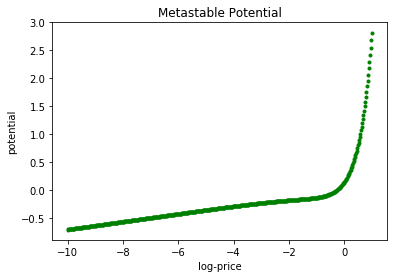

In [22]:
Ys = np.linspace(-10,1,500)
Vs = []
for y in Ys:
    v= Potential(y,theta = theta, sigma = sigma, kappa = kappa, g = g)
    Vs.append(v)

plt.scatter(Ys,Vs, marker='.', color='green',label='Curve')
plt.title(peta)
plt.xlabel('log-price')
plt.ylabel('potential')
plt.show()

### The potential looks flat on the left, which brings some lower vol to the left side. We can do some instinctive adjustment on one of the fetueres and check what will happen.

In [23]:
kramer_rate = KramerRate(a, b, theta = theta, sigma = sigma, kappa = kappa, g = g)
print("Kramer Rate is ", kramer_rate)

Kramer Rate is  2.50662827463


### What if we adjust? ...

In [24]:
theta= Theta_z
sigma= Sigma_z
kappa= Kappa_z -1
g= G_z


In [25]:
b,a, peta = InflectionPoints(theta = theta, sigma = sigma, kappa = kappa, g = g)

print( "------------------- Results ----------------------" )
print("Min=", b)
print("Max=", a)

------------------- Results ----------------------
Min= -2.95450811317
Max= 1.99700785775


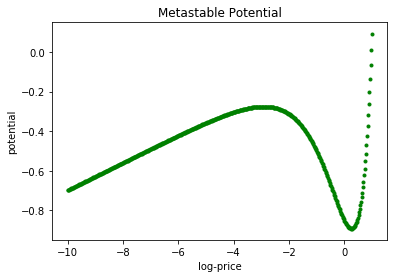

In [26]:
Ys = np.linspace(-10,1,500)
Vs = []
for y in Ys:
    v= Potential(y,theta = theta, sigma = sigma, kappa = kappa, g = g)
    Vs.append(v)

plt.scatter(Ys,Vs, marker='.', color='green',label='Curve')
plt.title(peta)
plt.xlabel('log-price')
plt.ylabel('potential')
plt.show()

#### More vol, but ...

In [27]:
kramer_rate = KramerRate(a, b, theta = theta, sigma = sigma, kappa = kappa, g = g)
print("Kramer Rate is ", kramer_rate)



Kramer Rate is  2.50662827463


#### Kramer rate doesn't change. Interesting!

## Part 3: Propose and analyse your own signals  (Max 10 points)

In this part, you will experiment with other signals. Propose a signal and explain why it is interesting to 
include this signal in the portfolio analysis. Then add your favorite signal or signals to the previous benchmarck signals (or alternatively you can replace them), and repeat the analysis of model calibration. State your conclusions.


### Let's try to work with EWMA just like we did back in course 3. Let's do it for the EWMA of 10 days.

In [28]:
exp_wgt_mov_avg_window_a = 10
exp_wgt_mov_avg_window_b = 50

exp_wgt_mov_avg_short = df_cap.ewm( span = exp_wgt_mov_avg_window_a,
                                              adjust = False ).mean()
exp_wgt_mov_avg_long = df_cap.ewm( span = exp_wgt_mov_avg_window_b,
                                             adjust = False ).mean()

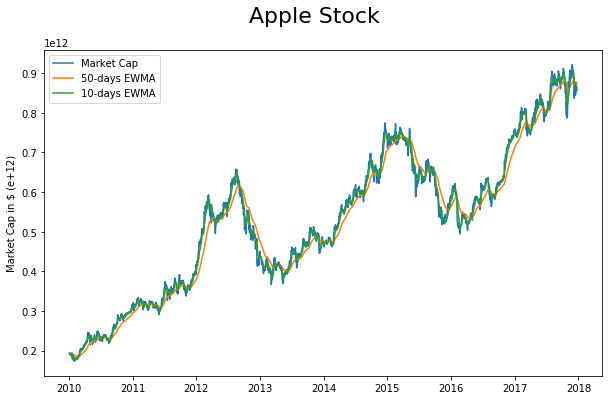

In [29]:
ticker = 'AAPL'
start_date = '2010-01-04'
end_date = '2017-12-22'
title="Apple Stock"
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
plt.suptitle(title, size=22)
ax.plot(df_cap.loc[start_date:end_date, :].index, df_cap.loc[start_date:end_date, 'AAPL'], label='Market Cap')

ax.plot(exp_wgt_mov_avg_long.loc[start_date:end_date, :].index, exp_wgt_mov_avg_long.loc[start_date:end_date, 'AAPL'], 
            label = '%d-days EWMA' % exp_wgt_mov_avg_window_b)
ax.plot(exp_wgt_mov_avg_short.loc[start_date:end_date, :].index, exp_wgt_mov_avg_short.loc[start_date:end_date, 'AAPL'], 
         label = '%d-days EWMA' % exp_wgt_mov_avg_window_a)

ax.legend(loc='best')
ax.set_ylabel('Market Cap in $ (e+12)')

plt.show()

#### Once again, we need to work on some data handling and calculate the necessary inputs for the model!

In [30]:
df_cap_norm = df_cap / df_cap.mean()
Signal_1 = df_cap_norm.ewm( halflife = exp_wgt_mov_avg_window_a).mean()
df_cap_norm_x = df_cap_norm.loc[Signal_1.index]
log_market_cap=np.log(df_cap_norm_x)
#Delta_Market_Cap=df_cap.pct_change(periods=1).shift(0)
Delta_Market_Cap_A=df_cap_norm.diff().dropna().shift(-1)
Delta_Market_Cap_A = Delta_Market_Cap_A / ( 1/252)
Delta_Market_Cap_A = Delta_Market_Cap_A.dropna()
Signal_1 = Signal_1.loc[Delta_Market_Cap_A.index]
log_market_cap = log_market_cap.loc[Delta_Market_Cap_A.index]


# Amount of time steps ...
t = log_market_cap.shape[0]

# Number of assets ...
n = log_market_cap.shape[1]

k=1

print( "------------------- Initial Parameters ----------------------" )
print("Number of assets: ", n)
print("Time Periods: ", t)
print("Factual Start Date: ", start_date)
print("Factual End Date: ", end_date)
print("Number of Signals (k): ", k)



------------------- Initial Parameters ----------------------
Number of assets:  30
Time Periods:  2078
Factual Start Date:  2010-01-04
Factual End Date:  2017-12-22
Number of Signals (k):  1


#### Starting with tensorflow basic model paramethers...

In [31]:
MAX_ITER = 5000
TOL_LOSS = 0.01
LEARNING_RATE = 0.1

TOL_PRM = 1e-4






convergence= pd.DataFrame( [],
                           index=np.arange(MAX_ITER+2),
                           columns = [ 'interation',
                                       'difference'])

#### Defining appropriate support functions to build the QED Model.

In [32]:
def Delta_ewma(Z, Y, theta= None, sigma = None, w = None, kappa = None, g = None ):
    return -(theta - 0.5 * sigma * sigma) + w * Z * Y + kappa * tf.math.exp(Y) + g * tf.math.exp(2.0*Y)


def Gaussian_Var_ewma(Z, Y, delta_Y, theta= None, sigma = None, w = None, kappa = None, g = None ):
    return delta_Y + Delta_ewma(Z, Y, theta= theta, sigma = sigma, w = w, kappa = kappa, g = g )


In [33]:
theta_init = 1.0
sigma_init = 1.0
w_init = 1.0
kappa_init = 1.0
g_init = 1.0


# Starting tensorflow graphing...
Y = tf.placeholder(dtype=tf.float64)
delta_Y = tf.placeholder(dtype=tf.float64)
Z = tf.placeholder(dtype=tf.float64)

theta = tf.Variable(initial_value=theta_init, dtype=tf.float64)
sigma = tf.Variable(initial_value=sigma_init, dtype=tf.float64)
w = tf.Variable(initial_value=w_init, dtype=tf.float64)
kappa = tf.Variable(initial_value=kappa_init, dtype=tf.float64)
g = tf.Variable(initial_value=g_init, dtype=tf.float64)

v = Gaussian_Var_ewma(Z, Y, delta_Y, theta= theta, sigma = sigma, w = w, kappa = kappa, g = g )
llm = Gaussian_log_prob(v, sigma)


#clip_w1 = w1.assign(tf.maximum(0., w1))
#clip_w2 = w2.assign(tf.maximum(0., w2))
#clip = tf.group(clip_w1, clip_w2)


optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
train_op = optimizer.minimize(llm, var_list=[theta,sigma,w,kappa,g])


val_theta, val_sigma, val_w, val_kappa, val_g = theta_init, sigma_init, w_init, kappa_init, g_init
new_val_theta, new_val_sigma, new_val_w, new_val_kappa, new_val_g = None, None, None, None,None

In [35]:
with tf.Session() as sess:
    sess.run(fetches=tf.global_variables_initializer())

    val_llm = sess.run(fetches=llm, feed_dict={Z:Signal_1, Y:log_market_cap, delta_Y :Delta_Market_Cap_A})
        
    i = 1
    
    print( "------------------- Running Calibration ----------------------" )
    print(" iter |       Difference       |   Error")
    
    while True:
        
        sess.run(fetches=train_op, feed_dict={Z:Signal_1, Y:log_market_cap, delta_Y :Delta_Market_Cap_A})
        #sess.run(clip) # force weights to be non-negative

        new_val_llm = sess.run(fetches=llm, feed_dict={Z:Signal_1, Y:log_market_cap, delta_Y :Delta_Market_Cap_A})
        
        diff = np.abs(new_val_llm - val_llm)
        
        val_llm = new_val_llm
        
        new_val_theta, new_val_sigma, new_val_w, new_val_kappa, new_val_g = sess.run(fetches=[theta,sigma,w,kappa, g])
        param_err = ( new_val_theta - val_theta )**2
        param_err += (new_val_sigma - val_sigma)**2
        param_err += (new_val_w - val_w)**2
        param_err += (new_val_kappa - val_kappa)**2
        param_err += (new_val_g - val_g)**2
        param_err = np.sqrt(param_err)

        val_theta, val_sigma, val_w, val_kappa, val_g = new_val_theta, new_val_sigma, new_val_w, new_val_kappa, new_val_g
        
        convergence.iat[i,0]=i
        convergence.iat[i,1]=diff
        
        
        
        print ("{:5} | {:16.4f} | {:12.4f}".format(i,diff,param_err), end="\r")
        
        
        if diff < TOL_LOSS:
            print('Loss function convergence in {} iterations!'.format(i))
            break
            
        if param_err < TOL_PRM:    
            print('parameters convergence in {} iterations!'.format(i))
            break


        if i >= MAX_ITER:
            print('Unable to converge. Max number of iterations reached without convergence.')
            break

        i += 1
        
        

        fitted_means = sess.run(theta, feed_dict={Z:Signal_1, Y:log_market_cap, delta_Y :Delta_Market_Cap_A})
        mean_levels = pd.DataFrame(fitted_means,index=log_market_cap.index,columns=log_market_cap.columns)

print( "------------------- Calibration Results ----------------------" )
print("theta=", new_val_theta)
print("sigma=", new_val_sigma)
#print("weights=", new_val_w)
print("kappa=",new_val_kappa)
print("g=",new_val_g)

------------------- Running Calibration ----------------------
 iter |       Difference       |   Error
Loss function convergence in 1557 iterations!
------------------- Calibration Results ----------------------
theta= 5.00759256253
sigma= 3.6473692314
kappa= -1.03922173889
g= -0.726945532413


### Let's check the convergence !!!

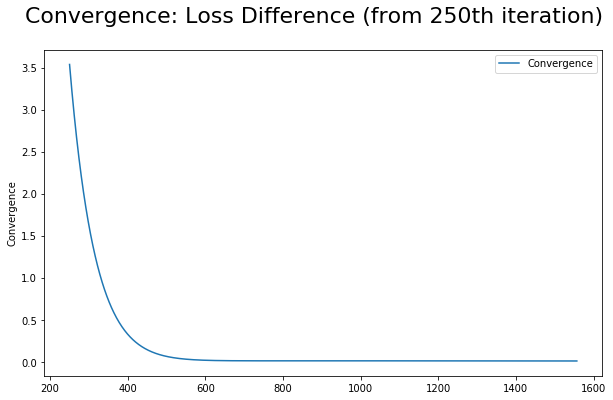

In [36]:
title = 'Convergence: Loss Difference (from 250th iteration)'

start_iter = 250
end_iter = i

fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(1,1,1)

plt.suptitle(title, size=22)
ax.plot(convergence.loc[start_iter:end_iter, :].index, convergence.loc[start_iter:end_iter, 'difference'], label='Convergence')

ax.legend(loc='best')
ax.set_ylabel('Convergence')

plt.show()

### How did it perform?

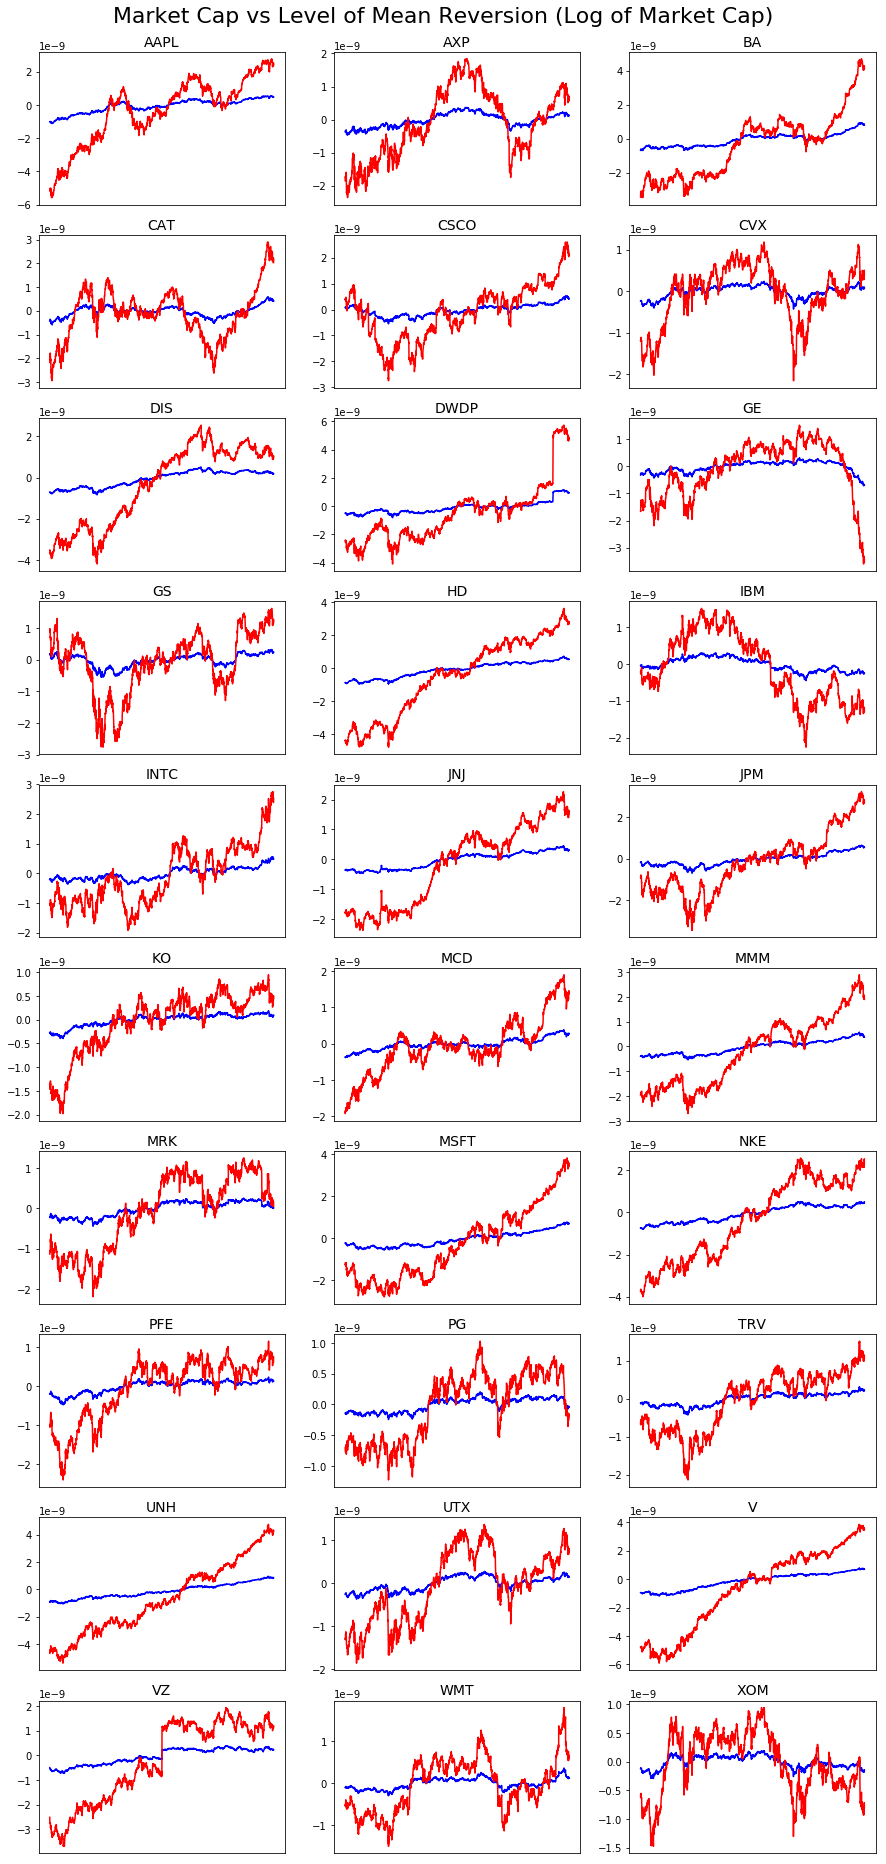

In [37]:
title = 'Market Cap vs Level of Mean Reversion (Log of Market Cap)'

N = df_cap.shape[1]

if N > n: N = n

plt.figure(figsize=(15,N))
plt.suptitle(title, size=22)
ytop = 0.96-0.4*np.exp(-N/5)
plt.subplots_adjust(top=ytop)

stocks = df_cap.columns[:N]
for index, stock in enumerate(stocks,1):
    plt.subplot(np.ceil(N/3),3,index)
    plt.plot((1/1e9)*log_market_cap.loc[start_date:end_date][stock],color='blue',label='Market cap ($Bn)')
    plt.plot((1/1e9)*log_market_cap.loc[start_date:end_date][stock]*mean_levels.loc[start_date:end_date][stock],color='red',label='Mean reversion level')
    plt.title(stock,size=14)
    plt.xticks([])
    
    
plt.show()

## Part 4 (Optional): Show me something else (Max 10 points).

Here you can develop any additional analysis of the model that you may find interesting (One possible suggestion is 
presented above, but you should feel free to choose your own topic). Present your case and finding/conclusions.


#### I must say I am out of ideas here... so I will do it simple by trying the longer EWMA. The code will be the same as in part 3, but adjusted to the 50 day EWMA. As Igor would say: "Let's get started!"

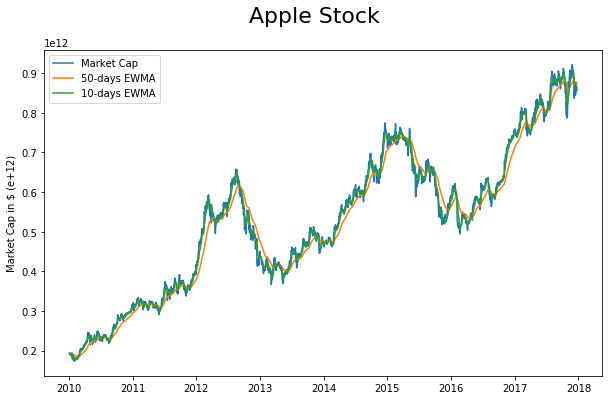

In [38]:
ticker = 'AAPL'
start_date = '2010-01-04'
end_date = '2017-12-22'
title="Apple Stock"
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
plt.suptitle(title, size=22)
ax.plot(df_cap.loc[start_date:end_date, :].index, df_cap.loc[start_date:end_date, 'AAPL'], label='Market Cap')

ax.plot(exp_wgt_mov_avg_long.loc[start_date:end_date, :].index, exp_wgt_mov_avg_long.loc[start_date:end_date, 'AAPL'], 
            label = '%d-days EWMA' % exp_wgt_mov_avg_window_b)
ax.plot(exp_wgt_mov_avg_short.loc[start_date:end_date, :].index, exp_wgt_mov_avg_short.loc[start_date:end_date, 'AAPL'], 
         label = '%d-days EWMA' % exp_wgt_mov_avg_window_a)

ax.legend(loc='best')
ax.set_ylabel('Market Cap in $ (e+12)')

plt.show()

#### Once again, we need to work on some data handling and calculate the necessary inputs for the model!

In [39]:
df_cap_norm = df_cap / df_cap.mean()
Signal_1 = df_cap_norm.ewm( halflife = exp_wgt_mov_avg_window_b).mean()
df_cap_norm_x = df_cap_norm.loc[Signal_1.index]
log_market_cap=np.log(df_cap_norm_x)
#Delta_Market_Cap=df_cap.pct_change(periods=1).shift(0)
Delta_Market_Cap_A=df_cap_norm.diff().dropna().shift(-1)
Delta_Market_Cap_A = Delta_Market_Cap_A / ( 1/252)
Delta_Market_Cap_A = Delta_Market_Cap_A.dropna()
Signal_1 = Signal_1.loc[Delta_Market_Cap_A.index]
log_market_cap = log_market_cap.loc[Delta_Market_Cap_A.index]


# Amount of time steps ...
t = log_market_cap.shape[0]

# Number of assets ...
n = log_market_cap.shape[1]

k=1

print( "------------------- Initial Parameters ----------------------" )
print("Number of assets: ", n)
print("Time Periods: ", t)
print("Factual Start Date: ", start_date)
print("Factual End Date: ", end_date)
print("Number of Signals (k): ", k)



------------------- Initial Parameters ----------------------
Number of assets:  30
Time Periods:  2078
Factual Start Date:  2010-01-04
Factual End Date:  2017-12-22
Number of Signals (k):  1


#### Starting with tensorflow basic model paramethers...

In [40]:
MAX_ITER = 5000
TOL_LOSS = 0.01
LEARNING_RATE = 0.1

TOL_PRM = 1e-4



convergence= pd.DataFrame( [],
                           index=np.arange(MAX_ITER+2),
                           columns = [ 'interation',
                                       'difference'])

#### Defining appropriate support functions to build the QED Model.

In [41]:
def Delta_ewma(Z, Y, theta= None, sigma = None, w = None, kappa = None, g = None ):
    return -(theta - 0.5 * sigma * sigma) + w * Z * Y + kappa * tf.math.exp(Y) + g * tf.math.exp(2.0*Y)


def Gaussian_Var_ewma(Z, Y, delta_Y, theta= None, sigma = None, w = None, kappa = None, g = None ):
    return delta_Y + Delta_ewma(Z, Y, theta= theta, sigma = sigma, w = w, kappa = kappa, g = g )


In [42]:
theta_init = 1.0
sigma_init = 1.0
w_init = 1.0
kappa_init = 1.0
g_init = 1.0


# Starting tensorflow graphing...
Y = tf.placeholder(dtype=tf.float64)
delta_Y = tf.placeholder(dtype=tf.float64)
Z = tf.placeholder(dtype=tf.float64)

theta = tf.Variable(initial_value=theta_init, dtype=tf.float64)
sigma = tf.Variable(initial_value=sigma_init, dtype=tf.float64)
w = tf.Variable(initial_value=w_init, dtype=tf.float64)
kappa = tf.Variable(initial_value=kappa_init, dtype=tf.float64)
g = tf.Variable(initial_value=g_init, dtype=tf.float64)

v = Gaussian_Var_ewma(Z, Y, delta_Y, theta= theta, sigma = sigma, w = w, kappa = kappa, g = g )
llm = Gaussian_log_prob(v, sigma)


#clip_w1 = w1.assign(tf.maximum(0., w1))
#clip_w2 = w2.assign(tf.maximum(0., w2))
#clip = tf.group(clip_w1, clip_w2)


optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
train_op = optimizer.minimize(llm, var_list=[theta,sigma,w,kappa,g])


val_theta, val_sigma, val_w, val_kappa, val_g = theta_init, sigma_init, w_init, kappa_init, g_init
new_val_theta, new_val_sigma, new_val_w, new_val_kappa, new_val_g = None, None, None, None,None

In [44]:
with tf.Session() as sess:
    sess.run(fetches=tf.global_variables_initializer())

    val_llm = sess.run(fetches=llm, feed_dict={Z:Signal_1, Y:log_market_cap, delta_Y :Delta_Market_Cap_A})
        
    i = 1
    
    print( "------------------- Running Calibration ----------------------" )
    print(" iter |       Difference       |   Error")
    
    while True:
        
        sess.run(fetches=train_op, feed_dict={Z:Signal_1, Y:log_market_cap, delta_Y :Delta_Market_Cap_A})
        #sess.run(clip) # force weights to be non-negative

        new_val_llm = sess.run(fetches=llm, feed_dict={Z:Signal_1, Y:log_market_cap, delta_Y :Delta_Market_Cap_A})
        
        diff = np.abs(new_val_llm - val_llm)
        
        val_llm = new_val_llm
        
        new_val_theta, new_val_sigma, new_val_w, new_val_kappa, new_val_g = sess.run(fetches=[theta,sigma,w,kappa, g])
        param_err = ( new_val_theta - val_theta )**2
        param_err += (new_val_sigma - val_sigma)**2
        param_err += (new_val_w - val_w)**2
        param_err += (new_val_kappa - val_kappa)**2
        param_err += (new_val_g - val_g)**2
        param_err = np.sqrt(param_err)

        val_theta, val_sigma, val_w, val_kappa, val_g = new_val_theta, new_val_sigma, new_val_w, new_val_kappa, new_val_g
        
        convergence.iat[i,0]=i
        convergence.iat[i,1]=diff
        
        
        
        print ("{:5} | {:16.4f} | {:12.4f}".format(i,diff,param_err), end="\r")
        
        
        if diff < TOL_LOSS:
            print('Loss function convergence in {} iterations!'.format(i))
            break
            
        if param_err < TOL_PRM:    
            print('parameters convergence in {} iterations!'.format(i))
            break


        if i >= MAX_ITER:
            print('Unable to converge. Max number of iterations reached without convergence.')
            break

        i += 1
        
        

        fitted_means = sess.run(theta, feed_dict={Z:Signal_1, Y:log_market_cap, delta_Y :Delta_Market_Cap_A})
        mean_levels = pd.DataFrame(fitted_means,index=log_market_cap.index,columns=log_market_cap.columns)

print( "------------------- Calibration Results ----------------------" )
print("theta=", new_val_theta)
print("sigma=", new_val_sigma)
#print("weights=", new_val_w)
print("kappa=",new_val_kappa)
print("g=",new_val_g)

------------------- Running Calibration ----------------------
 iter |       Difference       |   Error
Loss function convergence in 614 iterations!
------------------- Calibration Results ----------------------
theta= 4.71791453796
sigma= 3.64024486929
kappa= -1.48419079521
g= -0.548365496299


### Let's check the convergence !!!

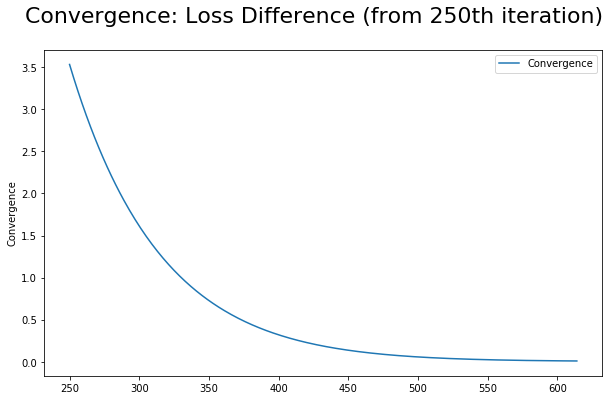

In [45]:
title = 'Convergence: Loss Difference (from 250th iteration)'

start_iter = 250
end_iter = i

fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(1,1,1)

plt.suptitle(title, size=22)
ax.plot(convergence.loc[start_iter:end_iter, :].index, convergence.loc[start_iter:end_iter, 'difference'], label='Convergence')

ax.legend(loc='best')
ax.set_ylabel('Convergence')

plt.show()

### The model converges way faster with EWMA and even faster is the window is longer. How did it perform?

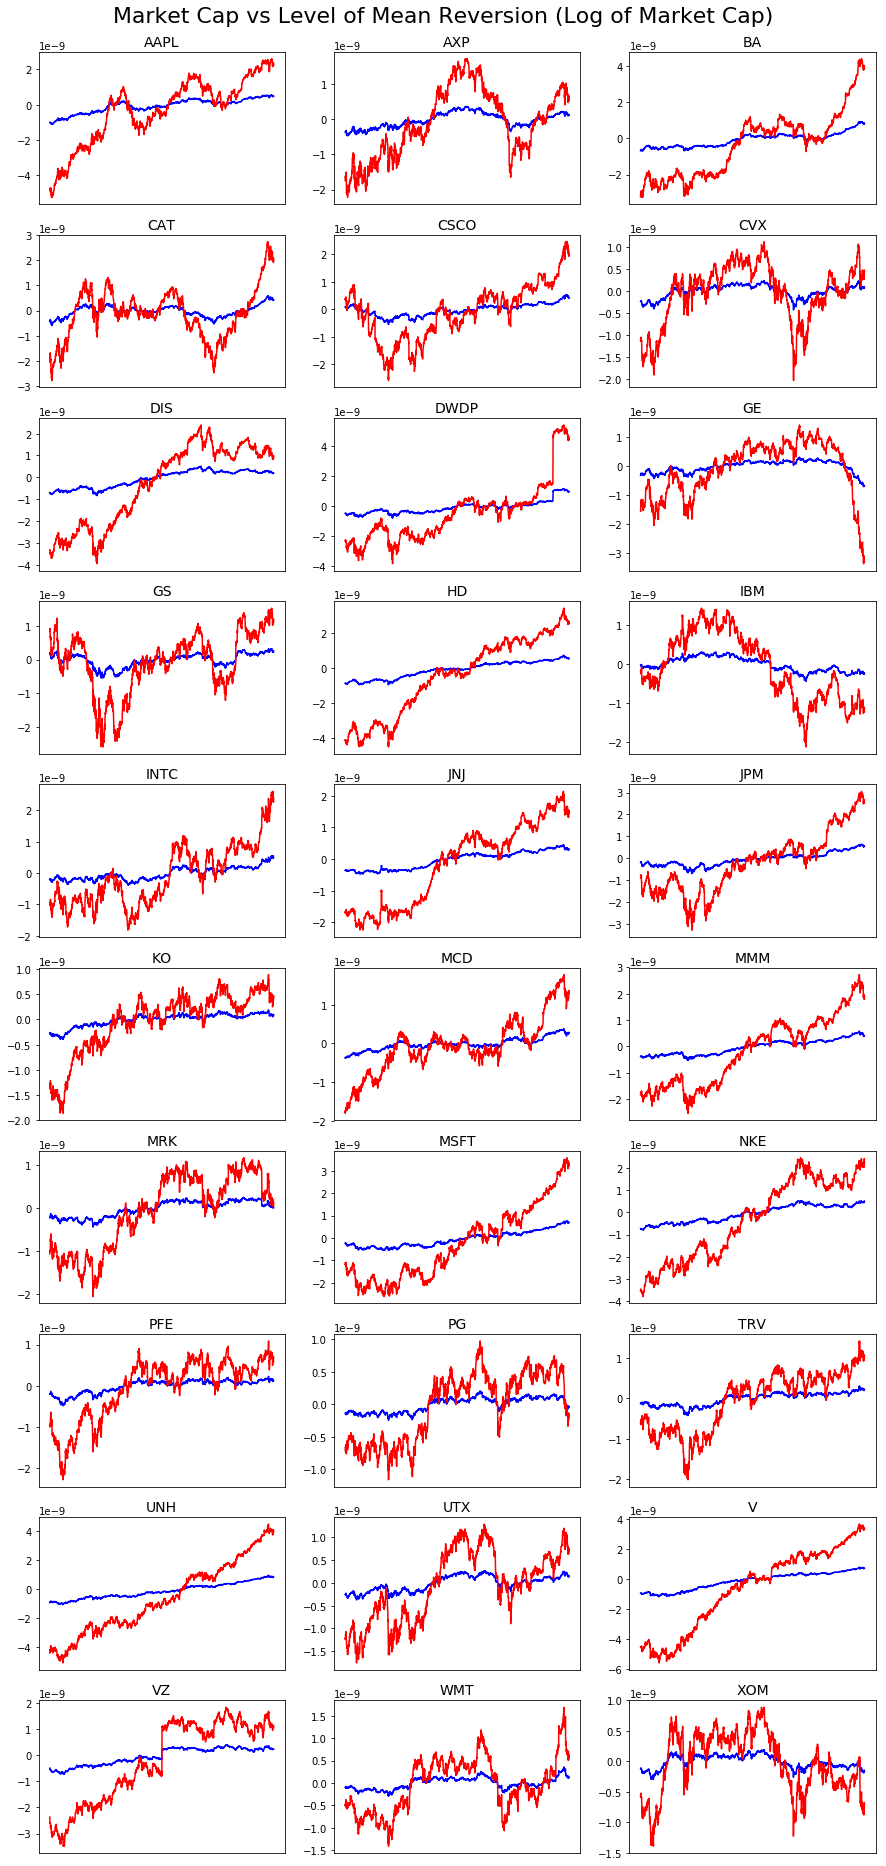

In [46]:
title = 'Market Cap vs Level of Mean Reversion (Log of Market Cap)'

N = df_cap.shape[1]

if N > n: N = n

plt.figure(figsize=(15,N))
plt.suptitle(title, size=22)
ytop = 0.96-0.4*np.exp(-N/5)
plt.subplots_adjust(top=ytop)

stocks = df_cap.columns[:N]
for index, stock in enumerate(stocks,1):
    plt.subplot(np.ceil(N/3),3,index)
    plt.plot((1/1e9)*log_market_cap.loc[start_date:end_date][stock],color='blue',label='Market cap ($Bn)')
    plt.plot((1/1e9)*log_market_cap.loc[start_date:end_date][stock]*mean_levels.loc[start_date:end_date][stock],color='red',label='Mean reversion level')
    plt.title(stock,size=14)
    plt.xticks([])
    
    
plt.show()

### DONE!!!

#### Or so I think ...